# Time Series Forecasting with LSTM Networks
*by 3 Pentium 4 in a trenchcoat: Pier Luigi Porri, Davide Edoardo Pellegrino, Lorenzo Morelli*

In this notebook we train and test a competent time series forecasting model on a dataset of 48000 indipendent sequences. Our model will be mainly composed of LSTM networks, imported from the Tensorflow package. Every choice, both structural and stylistic, will be explained either in a markdown cell or in code comments.

## Imports
First, we import what we need and we setup some things.

In [32]:
seed = 42                           #we set the seed for the random aspect.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings                    
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Loading and processing the dataset

In [33]:
training_data = np.load('/kaggle/input/time-series/training_data.npy', allow_pickle=True)
categories = np.load('/kaggle/input/time-series/categories.npy', allow_pickle=True)
valid_periods = np.load('/kaggle/input/time-series/valid_periods.npy', allow_pickle=True)

Since we plan on using a masking layer in the network, we start setting all the padding to the value that will be masked out.

In [34]:
for i in range(training_data.shape[0]):
    training_data[i, :valid_periods[i, 0]] = training_data[i, :valid_periods[i, 0]] - 1

Then, we plot a small sample of the dataset to see what it looks like.

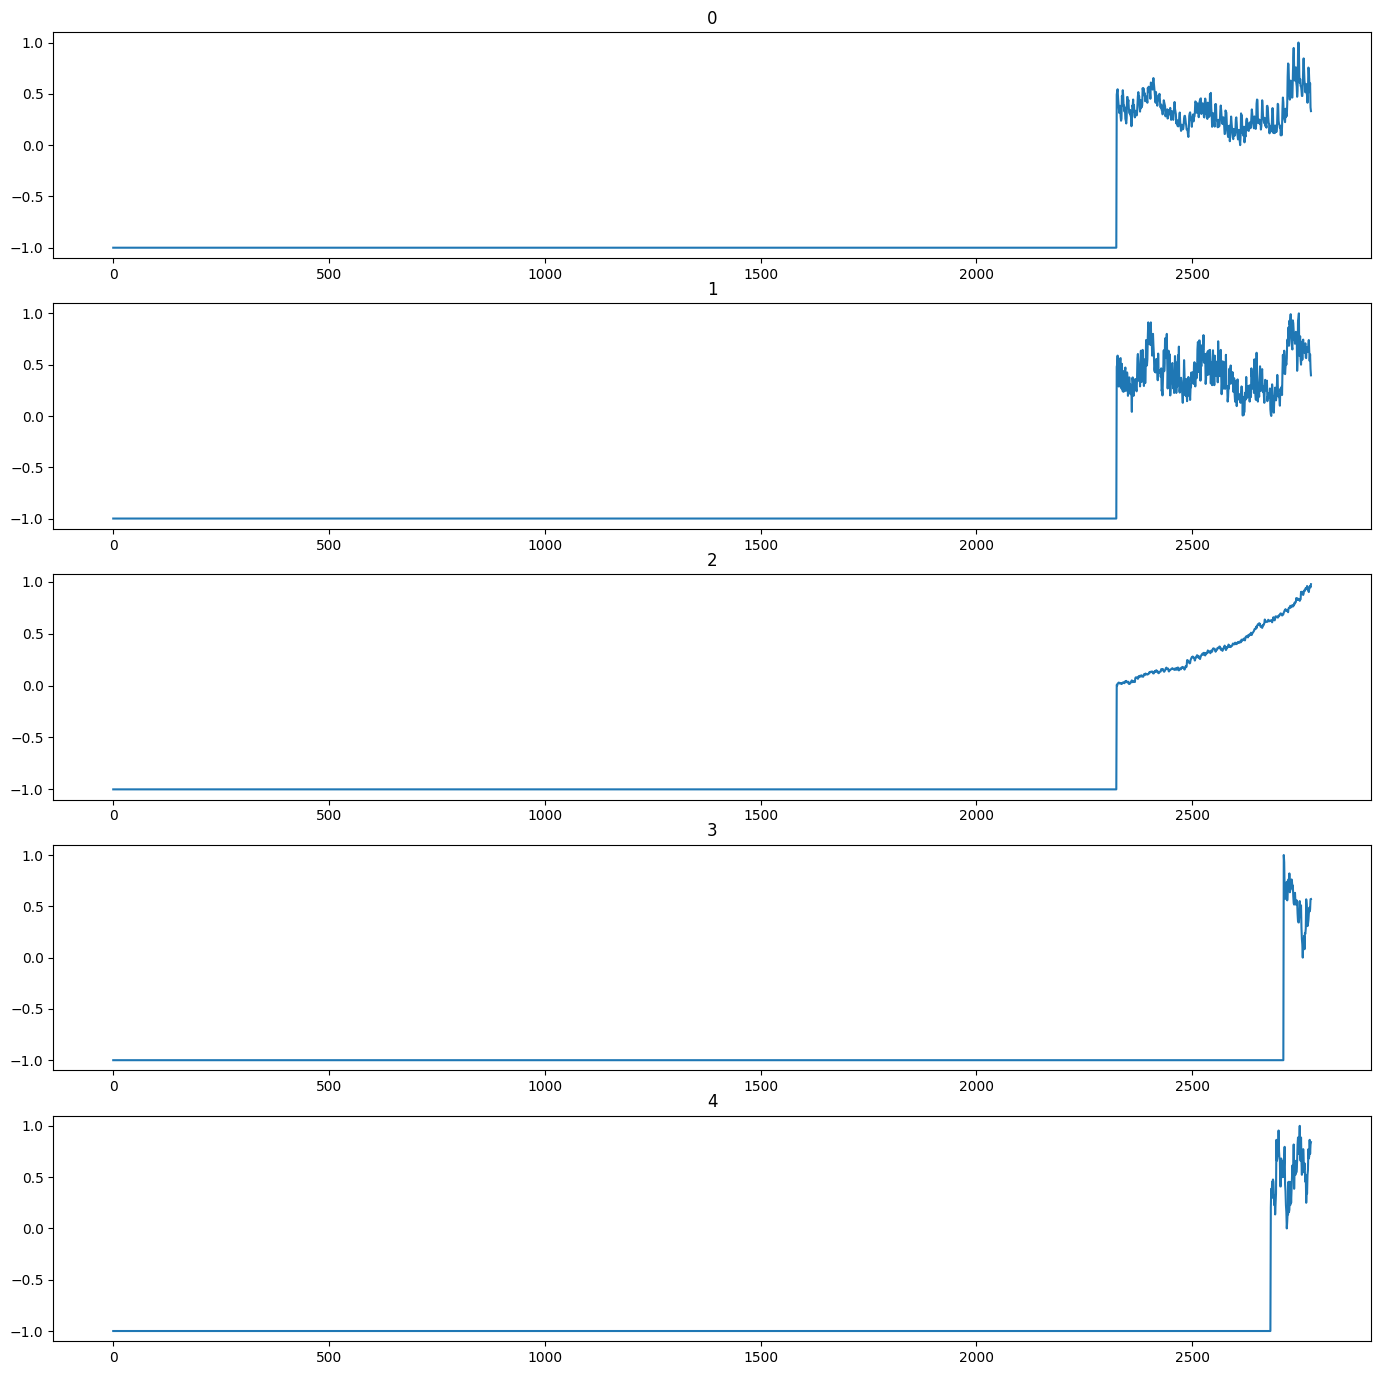

In [35]:
n_plots = 5

def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(columns, 1, figsize=(17,17))
    for i in range(columns):
        axs[i].plot(df[i])
        axs[i].set_title(i)
    plt.show()
    
inspect_dataframe(training_data[:n_plots], n_plots)

It's time to add the categories information to the dataset.

In [36]:
def add_categories(df, categories, cat=None):
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
    encoded = np.vectorize(label_mapping.get)(categories)
    result = []
    
    for i in range(df.shape[0]):
        timeseries = df[i]
        if cat is None:
            label = encoded[i]
            category = np.zeros((timeseries.shape[0], 6))
            category[:, int(label)] = 1
        else:
            category = cat[i]
        timeseries = np.expand_dims(timeseries, axis=-1)
        input_sequence = np.concatenate([timeseries, category], axis=-1)
        result.append(input_sequence)
    result = np.array(result)
    return result

In [37]:
training_data = add_categories(training_data, categories)

print(training_data.shape)

(48000, 2776, 7)


We now have a numpy array of 48000, 2776-long time series, comprised of 7 features: the first is our actual feature to predict, and the next 6 are the 6 categories in one-hot encoding.

Now, we proceed to split the dataset.

In [38]:
test_size = 0.1
slice_i = int(training_data.shape[0] * (test_size))            # we set the number of series in a slice
X_test_raw = training_data[-slice_i:]                          # we set the last slice for testing
X_val_raw = training_data[-2*slice_i:-slice_i]                 # the second to last slice to validation
X_train_raw = training_data[:-2*slice_i]                       # and the rest to training.

del training_data

print("Training Data Shape:", X_train_raw.shape)
print("Test Data Shape:", X_test_raw.shape)
print("Validation Data Shape:", X_val_raw.shape)

Training Data Shape: (38400, 2776, 7)
Test Data Shape: (4800, 2776, 7)
Validation Data Shape: (4800, 2776, 7)


Next, we build the sequences that are gonna be fed to the network.
"offset" is useful to set the starting point throughout the *valid_periods* array from which to start pulling the valid points, since our test, val and training sets are at differents points of the dataset.

In [39]:
def build_sequences(temp_df, offset, window=100, stride=10, telescope=9):
    assert window % stride == 0                                        # structural check
    X = []
    y = []
    padding_len = 0
    padding_check = temp_df.shape[1] % window                      # we check if the length of the sequence is a multiple of the window

    if padding_check != 0:                      # if not, we prepare some padding to ensure we have the same size on all sequences.                     
        padding_len = window - temp_df.shape[1] % window
        padding = np.zeros((temp_df.shape[0], padding_len, 7), dtype='float32') - 1
        temp_df = np.concatenate((padding, temp_df), axis = 1)
        del padding
        assert temp_df.shape[1] % window == 0    # then we check again.
        
    for j in np.arange(temp_df.shape[0]):        # then, we start building the actual sequences.
        start = valid_periods[j + offset, 0] + padding_len    # the offset is used to find the right valid periods.
        end = valid_periods[j + offset, 1] + padding_len
        length = end - start
        if length % window != 0:
            start = start - (window - (length % window))
            length = end - start
        for i in np.arange(start, end - window - telescope, stride): 
            X.append(temp_df[j, i:i + window])
            y.append(temp_df[j, i + window:i + window + telescope])
    
    del temp_df
    X = np.array(X)
    y = np.array(y)
    return X, y[:, :, 0]

In [40]:
X_train, y_train = build_sequences(X_train_raw, 0)
X_val, y_val = build_sequences(X_val_raw, 38400)           # 38400 is the number of time series already allocated to training, as seen before.
X_test, y_test = build_sequences(X_test_raw, 38400 + 4800) # 4800 is the same, but for validation.
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(585140, 100, 7) (585140, 9) (60510, 100, 7) (60510, 9) (31840, 100, 7) (31840, 9)


## Training the Model

Now that our inputs are ready, we can define the model.
We considered the use of GRUs, SimpleLSTM and/or Self Attention layers, but none performed better than this.
We chose to go with two concatenated LSTM layers, separated by dropout layers to mitigate overfitting, followed by a GAP1D layer to reduce the output to 1 dimension, and a dense layer to squeeze it all to our desired shape. 
Everything, as mentioned before, is preceded by a masking layer on the value -1.

In [41]:
def build_model(input_shape, output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')    
    
    x = tfkl.Masking(mask_value=-1)(input_layer)    
    x = tfkl.LSTM(160, return_sequences=True)(x)
    x = tfkl.Dropout(0.2)(x)
    
    x = tfkl.LSTM(80, return_sequences=True)(x)
    x = tfkl.Dropout(0.2)(x)
    
    x = tfkl.GlobalAveragePooling1D()(x)    
    x = tfkl.BatchNormalization()(x)    
    x = tfkl.Dense(output_shape, activation='linear')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x, name='LSTM')

    model.compile(loss='mse', optimizer='adam')
    return model

We define the input and output shapes by dropping the first dimension of both datasets.

In [42]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
print(input_shape, output_shape)

model = build_model(input_shape, output_shape)
model.summary()

(100, 7) 9
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 7)]          0         
                                                                 
 masking_3 (Masking)         (None, 100, 7)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 160)          107520    
                                                                 
 dropout_6 (Dropout)         (None, 100, 160)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           77120     
                                                                 
 dropout_7 (Dropout)         (None, 100, 80)           0         
                                                                 
 global_average_pooling1d_3  (None, 80)            

Training time.
The model is quite large, so we decided on small patience values to reduce training times.

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (X_val, y_val),
    verbose=1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]).history

Now we can plot the results.

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

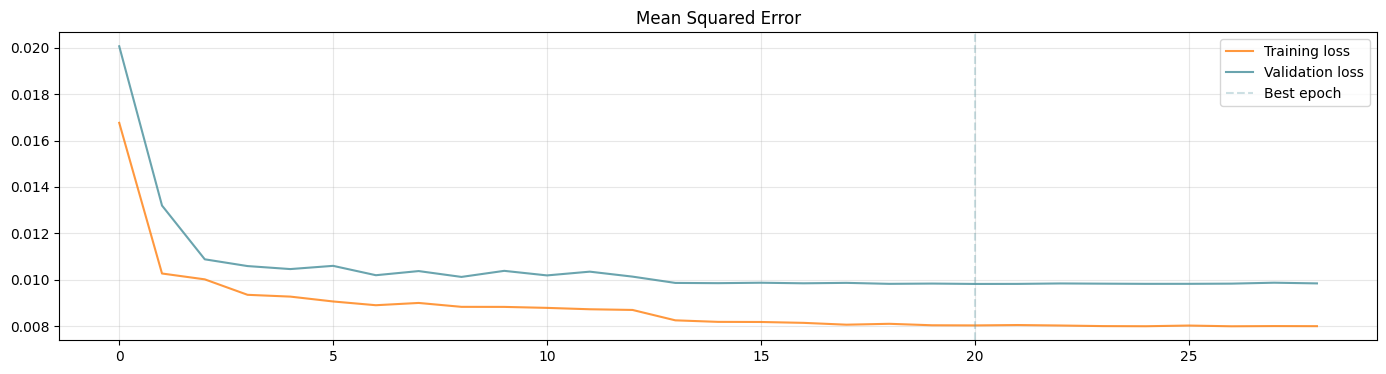
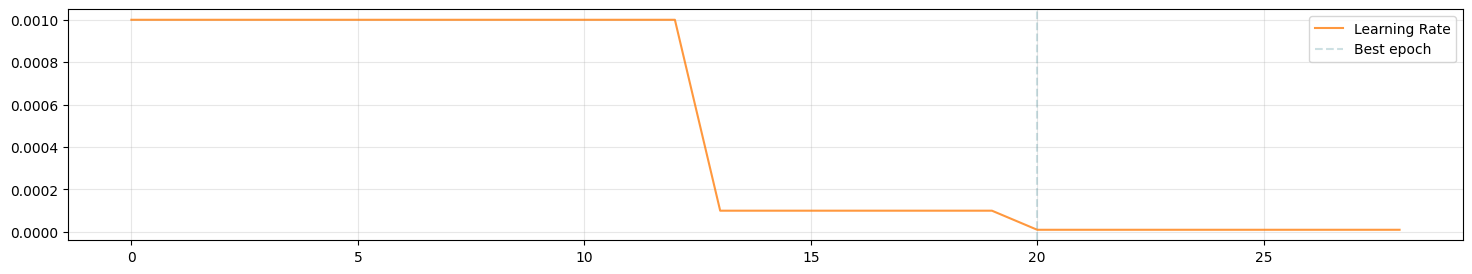

In [13]:
model.save('model')
model = tfk.models.load_model('model')

## Test the Model

Time to see the results. We test the model on the previously defined test set.

In [48]:
predictions = model.predict(X_test, verbose=0)

print(f"Predictions shape: {predictions.shape}")

mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (31840, 9)
Mean Squared Error: 0.009104005061089993
Mean Absolute Error: 0.060241132974624634


Let's see what our model actually did on 5 random sequences:

(9,)


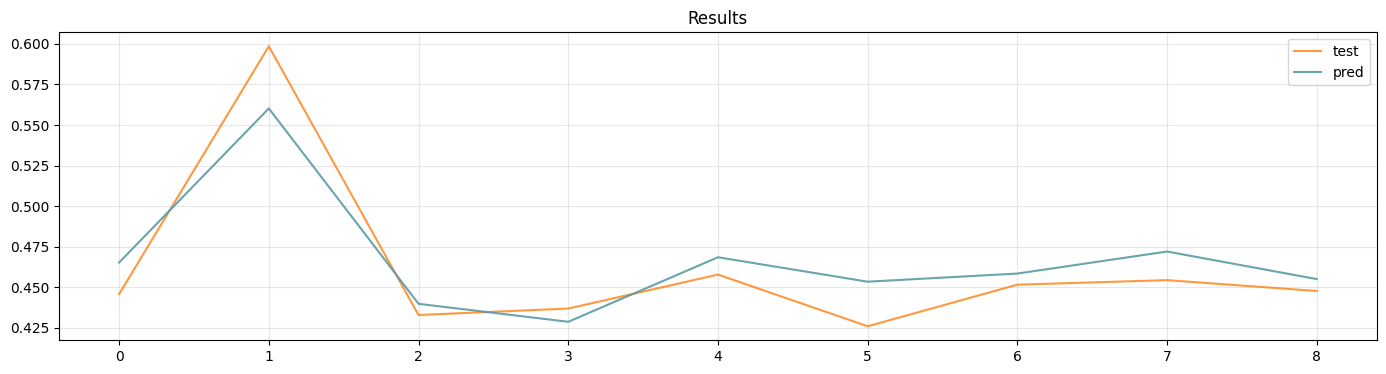

(9,)


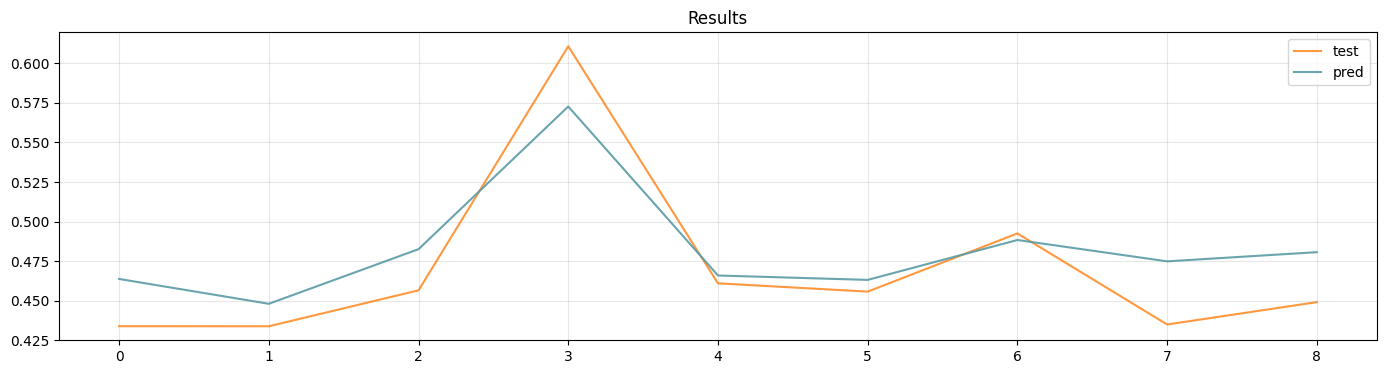

(9,)


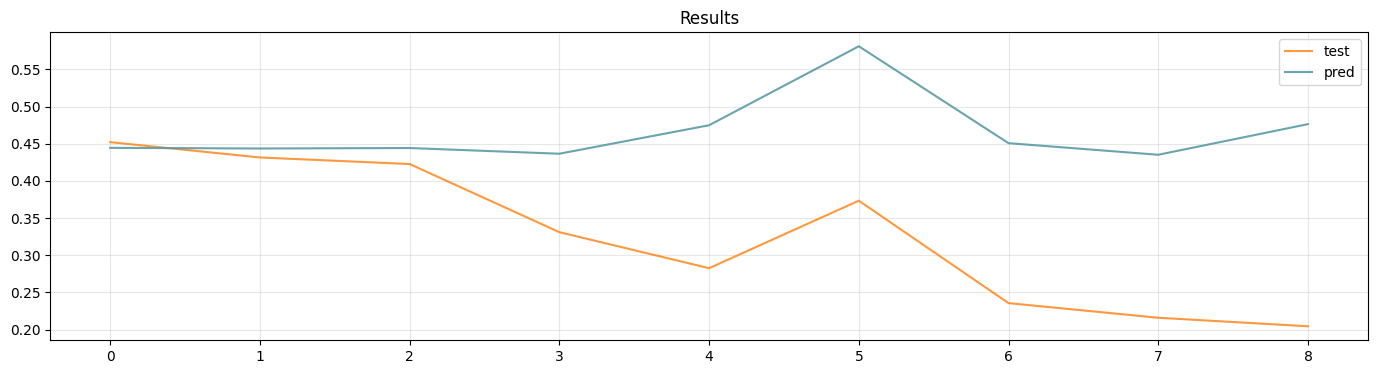

(9,)


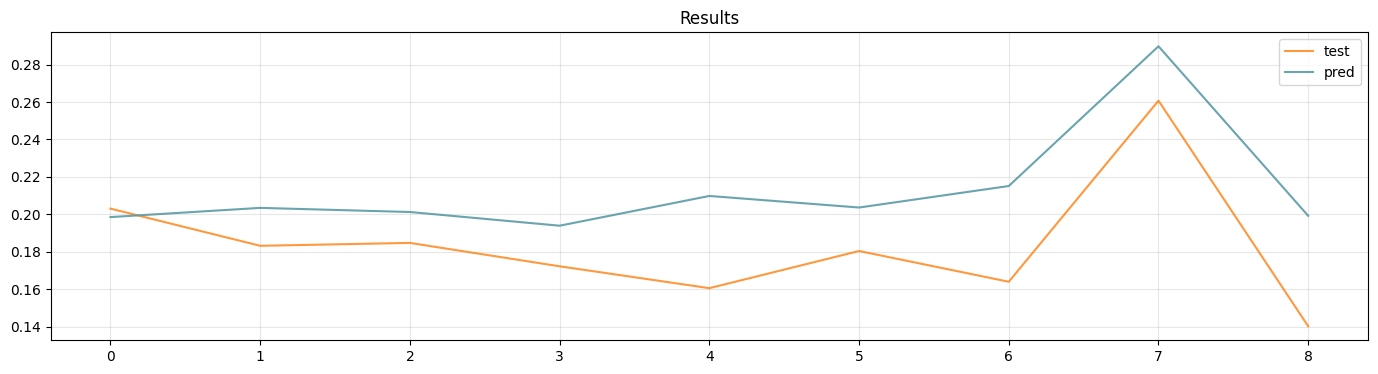

(9,)


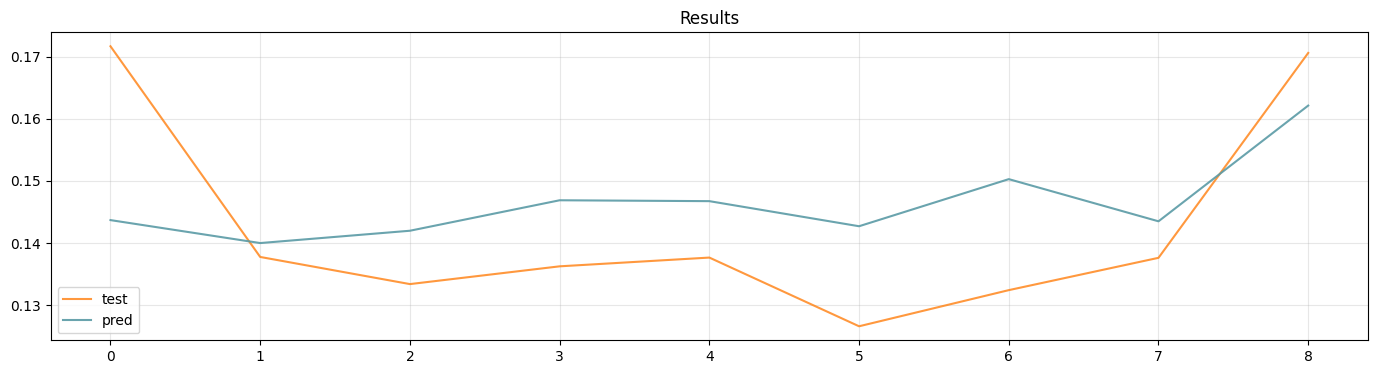

In [49]:
for i in range(4000, 4005):
    my_test = y_test[i]
    my_pred = predictions[i]
    
    print(my_pred.shape)
    
    plt.figure(figsize=(17,4))
    plt.plot(my_test, label='test', alpha=.8, color='#ff7f0e')
    plt.plot(my_pred, label='pred', alpha=.9, color='#5a9aa5')
    plt.title('Results')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Autoregression

To ensure our model is as sound as possible, we decided to apply some autoregression when predicting the next 18 points.
The *build_sequences* function is the same.

We predict the next 9 points, then we add the categories information and we use those points to make the next prediction.

In [50]:
autoregressive_telescope = 9
X_test_reg, y_test_reg = build_sequences(X_test_raw, 38400 + 4800, telescope = 18)
print("Autoregression shapes: ",X_test_reg.shape, y_test_reg.shape)

reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,18,autoregressive_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=-1)    
    pred_temp = add_categories(pred_temp, categories, cat=X_temp[:, -autoregressive_telescope:, 1:])
    X_temp = np.concatenate((X_temp[:, autoregressive_telescope:,:], pred_temp), axis=1)

Autoregression shapes:  (29671, 100, 7) (29671, 18)


Let's see how it does:

In [51]:
print(f"Predictions shape: {reg_predictions.shape}")
print(f"Predictions shape: {y_test_reg.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (29671, 18)
Predictions shape: (29671, 18)
Mean Squared Error: 0.014689810574054718
Mean Absolute Error: 0.07918195426464081


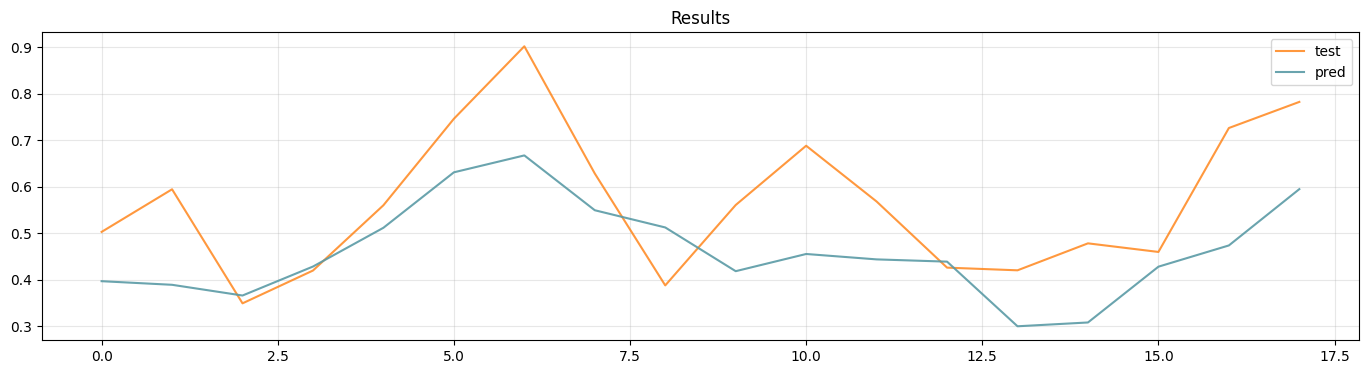

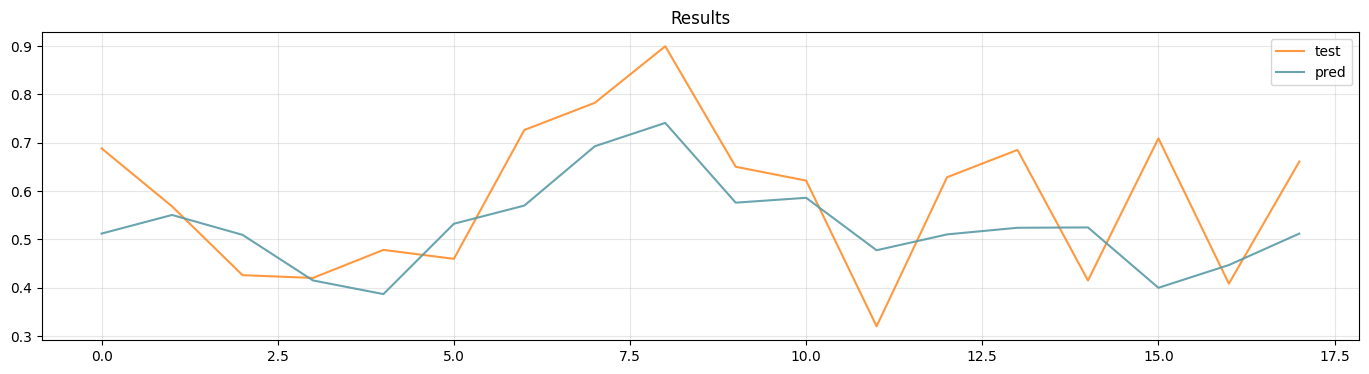

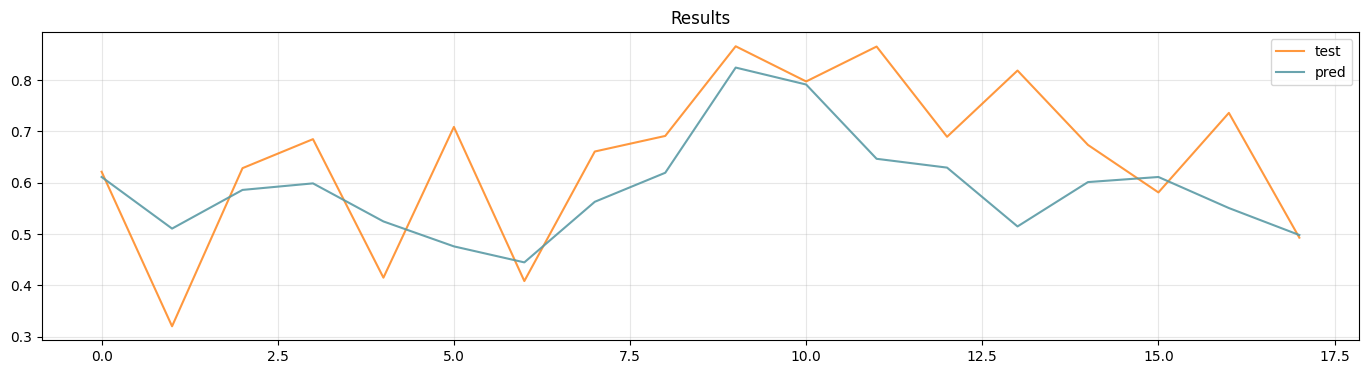

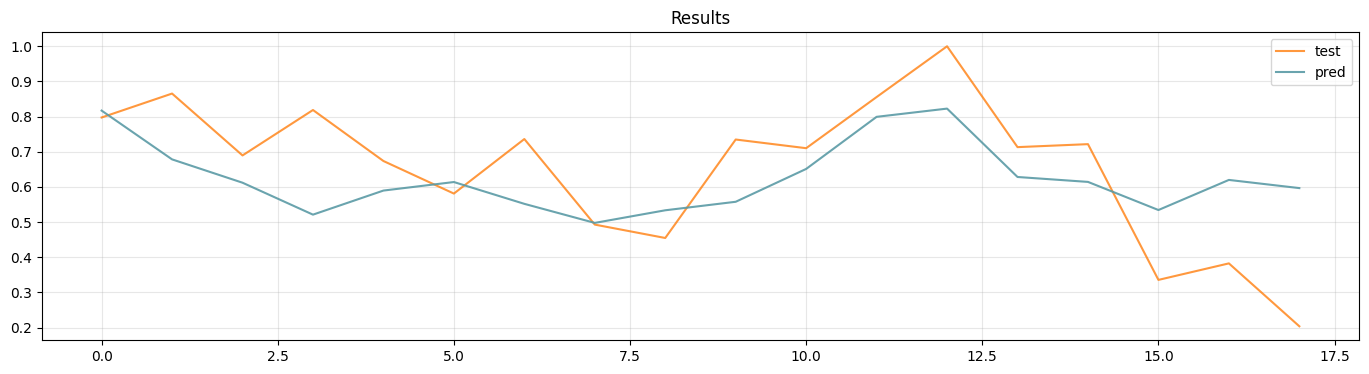

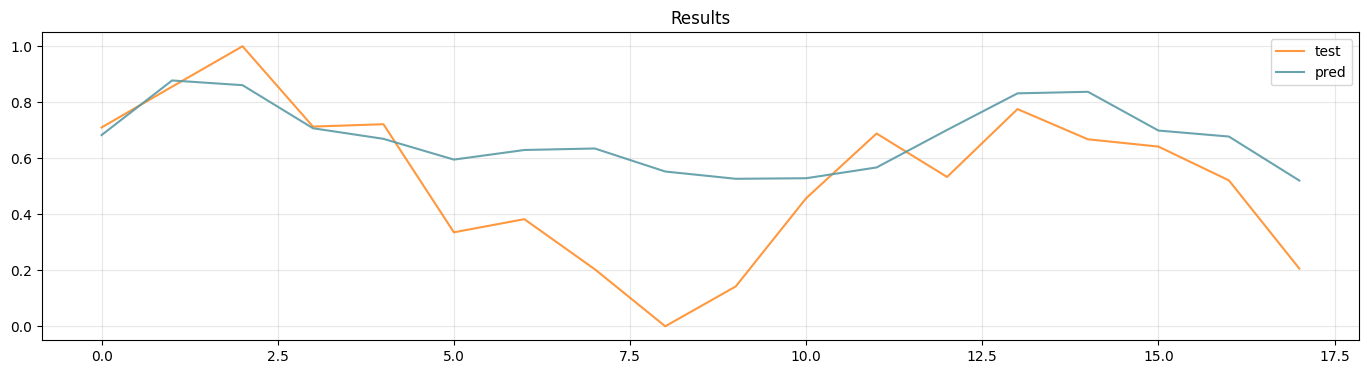

In [52]:
for i in range(400, 405):
    my_test = y_test_reg[i]
    my_pred = reg_predictions[i]
    plt.figure(figsize=(17,4))
    plt.plot(my_test, label='test', alpha=.8, color='#ff7f0e')
    plt.plot(my_pred, label='pred', alpha=.9, color='#5a9aa5')
    plt.title('Results')
    plt.legend()
    plt.grid(alpha=.3)